In [1]:
#importing libraries
import numpy as np
import pandas as pd
import nltk
import matplotlib.pyplot as plt
import statistics
import math
import os
from sklearn.model_selection import KFold, StratifiedKFold, cross_val_score
from sklearn.metrics import confusion_matrix
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
import re
pd.set_option('max_colwidth', 800)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


In [2]:
#loading dataset
df=pd.read_excel('/content/PMO translated Cleaned data.xlsx')
df.head()

,Survey Answer ID,Q10\nIs there anything else you would like to share with us?,Q11 translated,Q11\nno-translated
0,f91da0c6-602e-40b0-a96e-aef7469e6ebb,Compliments,thanks,thanks
1,3a836d06-fb1c-41a6-99aa-39202beb281c,Comment on the Service,good,good
2,7f6a288d-d2db-42df-9ee2-aba2b0a782ca,Comment on the Service,NICE SERVICES,NICE SERVICESS
3,c3e1f8d4-2956-4734-9571-6c31656484be,Comment on the Service,page response is unstable. rest is all fine,page respsonse is unstable. rest is all fine
4,a3d6ce90-d5e4-4214-8f14-3899d34e8980,Comment on the Service,THANKS,THANKS


In [3]:
df.shape

(29220, 4)

In [4]:
df.columns

Index(['Survey Answer ID',
       'Q10\nIs there anything else you would like to share with us?',
       'Q11 translated', 'Q11\nno-translated'],
      dtype='object')

In [5]:
### dropping unnecessary columns (id and no translated)
df = df.drop(['Survey Answer ID', 'Q11\nno-translated'], axis=1)
df.head()

,Q10\nIs there anything else you would like to share with us?,Q11 translated
0,Compliments,thanks
1,Comment on the Service,good
2,Comment on the Service,NICE SERVICES
3,Comment on the Service,page response is unstable. rest is all fine
4,Comment on the Service,THANKS


In [6]:
# renaming the column
df.rename(columns = {'Q10\nIs there anything else you would like to share with us?': 'label', 'Q11 translated' : 'text'}, inplace = True)
df.head()

,label,text
0,Compliments,thanks
1,Comment on the Service,good
2,Comment on the Service,NICE SERVICES
3,Comment on the Service,page response is unstable. rest is all fine
4,Comment on the Service,THANKS


In [7]:
df['label'].value_counts()

Comment on the Service    15523
Compliments               10658
others                     1638
Suggestion                 1356
compliments                  44
Compliments\n                 1
Name: label, dtype: int64

In [8]:
df['label'] = df['label'].str.replace('compliments', 'Compliments').replace('Compliments\n', 'Compliments')
df.head()

,label,text
0,Compliments,thanks
1,Comment on the Service,good
2,Comment on the Service,NICE SERVICES
3,Comment on the Service,page response is unstable. rest is all fine
4,Comment on the Service,THANKS


In [9]:
df['label'].value_counts()

Comment on the Service    15523
Compliments               10703
others                     1638
Suggestion                 1356
Name: label, dtype: int64

### DATA PREPROCESSING

In [10]:
z = {'Comment on the Service' : 0, 'Compliments' : 1, 'Suggestion' : 2, 'others' : 3}  # 1 for truthful reviews and 0 for deceptive reviews
df['label'] = df['label'].map(z)

In [11]:
df.head()

,label,text
0,1,thanks
1,0,good
2,0,NICE SERVICES
3,0,page response is unstable. rest is all fine
4,0,THANKS


In [12]:
# Cleaning Raw tweets
def clean_text(text):
    
    #remove emails
    text = ' '.join([i for i in text.split() if '@' not in i])
    
    #remove web address
    text = re.sub('http[s]?://\S+', '', text)

    #remove brackets and parantheses (and removing the text inside the brackets and parantheses)
    text = re.sub("[\(\[].*?[\)\]]", "", text)

    #remove punctuations
    text = re.sub(r'[^\w\s]', ' ', text)
    
    #Filter to allow only alphabets and numbers
    text = re.sub(r'[^a-zA-Z\']', ' ', text)
    
    #Remove Unicode characters
    text = re.sub(r'[^\x00-\x7F]+', '', text)

    #remove double spaces 
    text = re.sub('\s+', ' ', text)

    #remove more than 15 characters
    text = re.sub(r'\b\w{16,}\b', '', text)
    
    return text

In [13]:
# applying that into function.
df["clean_text"] = df['text'].apply(lambda x: clean_text(x))
df.head()

,label,text,clean_text
0,1,thanks,thanks
1,0,good,good
2,0,NICE SERVICES,NICE SERVICES
3,0,page response is unstable. rest is all fine,page response is unstable rest is all fine
4,0,THANKS,THANKS


In [14]:
# dropping the uncleaned text column "text"
df = df.drop(['text'], axis=1)

In [15]:
# renaming the column
df.rename(columns = {'clean_text':'text'}, inplace = True)
df.head()

,label,text
0,1,thanks
1,0,good
2,0,NICE SERVICES
3,0,page response is unstable rest is all fine
4,0,THANKS


In [16]:
import spacy
#loading the english language small model of spacy
en = spacy.load('en_core_web_sm')
sw_spacy = en.Defaults.stop_words
print(sw_spacy)

{'more', 'therein', 'somewhere', 'several', 'therefore', 'doing', 'will', 'whoever', 'once', 'enough', 'throughout', 'for', 'eleven', 'yourselves', 'is', 'himself', 'see', 'n’t', 'nowhere', 'it', 'should', 'first', 'i', 'down', 'her', 'herself', 'latter', 'why', 'who', 'go', 'few', 'whence', 'take', 'fifty', 'hers', 'then', 'what', 'onto', 'does', 'least', 'across', 'out', 'meanwhile', '’d', 'among', 'where', 'side', 'hundred', 'someone', 'the', 'whereafter', 'she', 'thence', 'very', 'after', 'but', 'thereupon', 'since', 'every', 'its', 'make', 'thus', 'as', 'together', 'over', 'until', 'sometimes', 'how', 'wherein', 'beside', 'also', 'between', 'get', 'yourself', 'perhaps', 'put', 'can', 'seem', 'now', "'re", "'m", 'into', 'which', 'using', 'and', 'nor', '‘ll', 'almost', 'front', 'that', '‘ve', 'of', 'per', 'somehow', 'thru', 'namely', 'five', 'nevertheless', 'other', 'there', 'used', 'ever', 'so', 'am', 'became', 'herein', 'everyone', 'along', 'although', 'hereafter', 'has', 'cannot'

In [17]:
import nltk
from nltk.corpus import stopwords
sw_nltk = stopwords.words('english')
print(sw_nltk)

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

In [18]:
df['text'][16]

''

In [19]:
# preprocessing the data (removing stopwords, convert the sentence to lower case, and also applying lemmatization to get meaningful words )
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
wnl=WordNetLemmatizer()
def clean_text(review):
  review = review.lower()
  review = review.split()
  review = [wnl.lemmatize(word) for word in review if word not in sw_nltk]
  #review = [wnl.lemmatize(word) for word in review if word not in sw_spacy]
  review = [wnl.lemmatize(word) for word in review if word not in set(stopwords.words('english'))]
  review = ' '.join(review)
  return review

In [20]:
df['text']=df['text'].apply(clean_text)
df.head()

,label,text
0,1,thanks
1,0,good
2,0,nice service
3,0,page response unstable rest fine
4,0,thanks


In [21]:
df['text'][16]

''

Empty rows are present. And single letter words and double letters words are present. So we are removing these.  

In [22]:
#removing single letter words and double letters words 
df['text'] = df['text'].str.replace(r'\b\w{1,2}\b', '', regex=True)
df.head()

,label,text
0,1,thanks
1,0,good
2,0,nice service
3,0,page response unstable rest fine
4,0,thanks


In [23]:
# removing empty rows
df = df[df['text'].apply(lambda x: len(x) > 0)]

In [24]:
df['text'][15]

'thanks'

In [25]:
df.reset_index(inplace=True)
df.head(20)

,index,label,text
0,0,1,thanks
1,1,0,good
2,2,0,nice service
3,3,0,page response unstable rest fine
4,4,0,thanks
5,5,1,thanks
6,6,0,system error message
7,7,0,good
8,8,0,page response unstable rest fine
9,9,0,good happy keep good thing going good day


In [26]:
# dropping the uncleaned text column "text"
df = df.drop(['index'], axis=1)
df.head()

,label,text
0,1,thanks
1,0,good
2,0,nice service
3,0,page response unstable rest fine
4,0,thanks


In [27]:
# after cleaning the data, we have 26618 rows
df.shape

(26618, 2)

### Removing names

In [28]:
# function to remove names
def remove_names(text):
    # define regular expression pattern to match names
    pattern = re.compile(r'\b(?:abd|abdouli|abdul|abdulaziz|adel|abdullah|abdulrahman|abrar|abeer|abi|adn|adu|ahmad|ahmed|ahood|aht|alabdooli|alabdouli|alachram|alaghbari|alc|alhamdulillah|alhamoor|ali|alia|alif|alkindi|allah|allhumdulliah|allo|alqubaisi|alsalaam|alsoor|alykom|amal|amata|amed|amen|amer|amis|ammar|amoudi|amra|amsat|amwal|ana|andrew|anf|anz|aqsa|atta|atleat|asharj|ashkram|asif|asim|asma|asmaa|awael|awatef|ayash|ayisha|ayman|azhar|azza|badr|badria|badriya|bahia|bakr|balakrishnan|balooshi|balushi|baniyas|bara|baraem|barsh|bastaki|batayneh|bilal|bint|biyyat|brian|bthe|budaiwi|issy|ive|jaddaf|jafar|jafiliya|jahili|jalal|jamal||janan|janoubi|jasmine|jassim|jazak|jazeera|jebel|jeel|jihadjoseline|juma|jumaia|jvc|kalba|kalban|kareem|katyn|kawkaba|keji|kenneth|khabisi|khaili|khaimah|khair|khalaf|khaled|khalid|khalifa|khamis|kharma|khatib|khatm|khattab|khazna|khor|khorfakkan|kjhgfds|kkk|kmz|konain|kumz|kutty|kvito|kyrgyz|dadsad|sddaddad|sdsds||sha|shaer|shafei|shah|shahama|shakhbout|shama|shamikha|shamkha|shamsa|shamsi|shanahan|sharifa|sharq|shatha|shawamekh|shd|shefaa|shehhi|sheikh|sheikha|shiva|shkran|soo|sooo|soooo|sooooo|soooooo|soumya|sadsadsad|sssasss|suhail|suhaila|suhair|sukkah|szhp|taha|tahaluf|taharba|umm|umrah|xia|yabladi|yas|yasmine|yassin|yousef|youssef|youssefni|ypu|yuen|zaabi|zahir|zakher|zaki|zarooni|zakat|zayed|zina|zindabad|ziyad|zubaida|zuhair)\b', re.IGNORECASE)
    return re.sub(pattern, '', text)

# apply the function to the text column
df['text'] = df['text'].apply(remove_names)

### Preprocess city name

In [29]:
# function to remove places
def replace_places(text):
    # define regular expression pattern to match places
    pattern = re.compile(r'\b(?:abu dhabi|abu|dhabi)\b', re.IGNORECASE)
    return re.sub(pattern, 'abudhabi', text)

# apply the function to the text column
df['text'] = df['text'].apply(replace_places)

In [30]:
x = df['text']
y = df['label']

### FEATURE EXTRACTION USING TFIDF

In [31]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer 
from sklearn.feature_extraction.text import TfidfVectorizer
cv=TfidfVectorizer()
corpii=cv.fit_transform(x) 

In [32]:
feature_names = cv.get_feature_names_out()
len(feature_names)

4941

In [33]:
u1 = pd.DataFrame(corpii.toarray(), columns=feature_names)
u1.head()

,abbreviation,ability,able,abort,abroad,absence,absent,absolutely,abstract,abudhabi,...,yes,yesterday,yet,youconvenience,young,youth,zero,zip,zone,zoom
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### TRAIN TEST SPLIT

In [34]:
x = u1
y = df['label']

In [35]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=7, stratify=y)

### MODEL BUILDING

### LINEAR SUPPORT VECTOR MACHINE

In [36]:
{'Comment on the Service' : 0, 'Compliments' : 1, 'Suggestion' : 2, 'others' : 3} 

{'Comment on the Service': 0, 'Compliments': 1, 'Suggestion': 2, 'others': 3}

In [37]:
from sklearn.svm import LinearSVC
lsvm = LinearSVC()
lsvm.fit(x_train, y_train)
y_pred=lsvm.predict(x_test)
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred, target_names=['Comment on the Service', 'Compliments', 'Suggestion', 'others']))
lsvm =  accuracy_score(y_test, y_pred)
print('accuracy_score: ', lsvm)

[[2442  184   79   15]
 [ 216 1893   11    9]
 [ 149   12  104    3]
 [  85   68    6   48]]
                        precision    recall  f1-score   support

Comment on the Service       0.84      0.90      0.87      2720
           Compliments       0.88      0.89      0.88      2129
            Suggestion       0.52      0.39      0.44       268
                others       0.64      0.23      0.34       207

              accuracy                           0.84      5324
             macro avg       0.72      0.60      0.63      5324
          weighted avg       0.83      0.84      0.83      5324

accuracy_score:  0.8427873779113448


In [38]:
cm = confusion_matrix(y_test, y_pred)

In [39]:
# https://github.com/DTrimarchi10/confusion_matrix/blob/master/cf_matrix.py
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def make_confusion_matrix(cf,
                          group_names=None,
                          categories='auto',
                          count=True,
                          percent=True,
                          cbar=True,
                          xyticks=True,
                          xyplotlabels=True,
                          sum_stats=True,
                          figsize=None,
                          cmap='Blues',
                          title=None):
    
    # CODE TO GENERATE TEXT INSIDE EACH SQUARE
    blanks = ['' for i in range(cf.size)]

    if group_names and len(group_names)==cf.size:
        group_labels = ["{}\n".format(value) for value in group_names]
    else:
        group_labels = blanks

    
    if percent:
        group_percentages = ["{0:.2%}".format(value) for value in cf.flatten()/np.sum(cf)]
    else:
        group_percentages = blanks

    
    box_labels = [f"{v1}{v2}".strip() for v1, v2 in zip(group_labels, group_percentages)]
    box_labels = np.asarray(box_labels).reshape(cf.shape[0],cf.shape[1])


    # CODE TO GENERATE SUMMARY STATISTICS & TEXT FOR SUMMARY STATS
    if sum_stats:
        #Accuracy is sum of diagonal divided by total observations
        accuracy  = np.trace(cf) / float(np.sum(cf))

        #if it is a binary confusion matrix, show some more stats
        if len(cf)==2:
            #Metrics for Binary Confusion Matrices
            precision = cf[1,1] / sum(cf[:,1])
            recall    = cf[1,1] / sum(cf[1,:])
            f1_score  = 2*precision*recall / (precision + recall)
            stats_text = "\n\nAccuracy={:0.3f}\nPrecision={:0.3f}\nRecall={:0.3f}\nF1 Score={:0.3f}".format(
                accuracy,precision,recall,f1_score)
        else:
            stats_text = "\n\nAccuracy={:0.3f}".format(accuracy)
    else:
        stats_text = ""


    # SET FIGURE PARAMETERS ACCORDING TO OTHER ARGUMENTS
    if figsize==None:
        #Get default figure size if not set
        figsize = plt.rcParams.get('figure.figsize')

    if xyticks==False:
        #Do not show categories if xyticks is False
        categories=False


    # MAKE THE HEATMAP VISUALIZATION
    plt.figure(figsize=figsize)
    sns.heatmap(cf,annot=box_labels,fmt="",cmap=cmap,cbar=cbar,xticklabels=categories,yticklabels=categories)

    if xyplotlabels:
        
        plt.xlabel(stats_text)
    else:
        plt.xlabel(stats_text)
    
    if title:
        plt.title(title)

In [40]:
categories = ['Comment on the Service', 'Compliments', 'Suggestion', 'others']


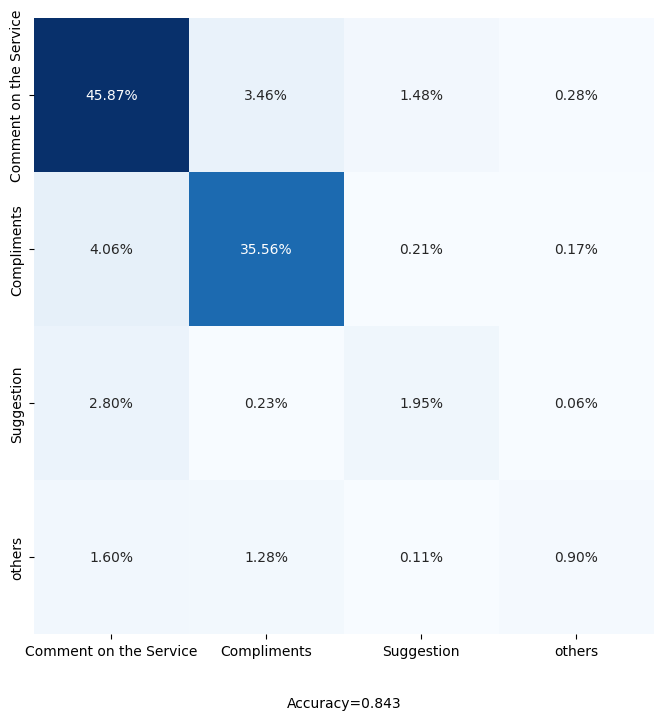

In [41]:
make_confusion_matrix(cm, figsize=(8,8), categories=categories, cbar=False)

### PASSIVE AGGRESSIVE CLASSIFIER

In [42]:
from sklearn.linear_model import PassiveAggressiveClassifier
pa=PassiveAggressiveClassifier(max_iter=1000, random_state=7, tol=1e-3)
pa.fit(x_train, y_train)
y_pred=pa.predict(x_test)
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred, target_names=['Comment on the Service', 'Compliments', 'Suggestion', 'others']))
pa =  accuracy_score(y_test, y_pred)
print('accuracy_score: ', pa)

[[2376  189  133   22]
 [ 217 1879   20   13]
 [ 137   16  113    2]
 [  69   73   14   51]]
                        precision    recall  f1-score   support

Comment on the Service       0.85      0.87      0.86      2720
           Compliments       0.87      0.88      0.88      2129
            Suggestion       0.40      0.42      0.41       268
                others       0.58      0.25      0.35       207

              accuracy                           0.83      5324
             macro avg       0.68      0.61      0.62      5324
          weighted avg       0.82      0.83      0.82      5324

accuracy_score:  0.830015026296018


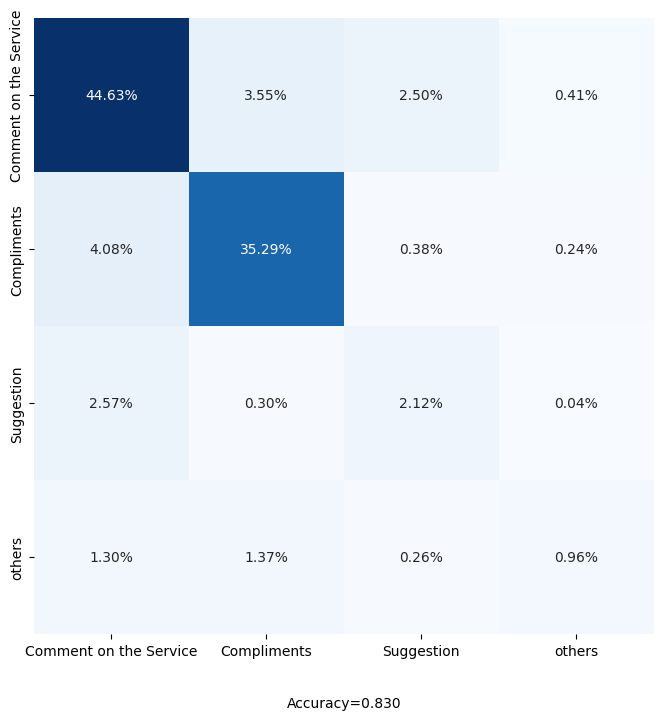

In [43]:
cm = confusion_matrix(y_test, y_pred)
make_confusion_matrix(cm, figsize=(8,8), categories=categories, cbar=False)

### MULTINOMIAL NAIVE BAYES

In [44]:
from scipy.special import nbdtr
from sklearn.naive_bayes import MultinomialNB
mnb=MultinomialNB(alpha=1.0)
mnb.fit(x_train, y_train)
y_pred=mnb.predict(x_test)
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred, target_names=['Comment on the Service', 'Compliments', 'Suggestion', 'others']))
nb =  accuracy_score(y_test, y_pred)
print('accuracy_score: ', nb)

[[2541  165   14    0]
 [ 252 1875    1    1]
 [ 221   10   37    0]
 [  97   71    1   38]]
                        precision    recall  f1-score   support

Comment on the Service       0.82      0.93      0.87      2720
           Compliments       0.88      0.88      0.88      2129
            Suggestion       0.70      0.14      0.23       268
                others       0.97      0.18      0.31       207

              accuracy                           0.84      5324
             macro avg       0.84      0.53      0.57      5324
          weighted avg       0.84      0.84      0.82      5324

accuracy_score:  0.8435386927122465


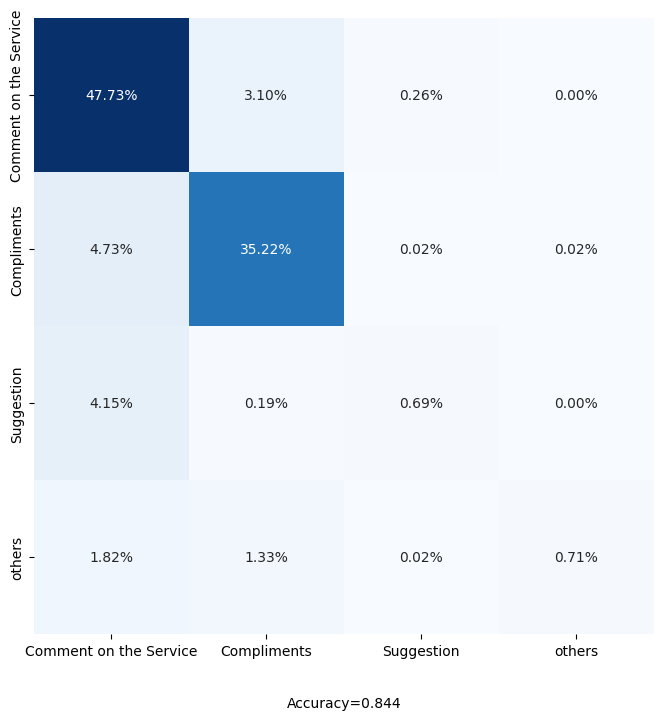

In [45]:
cm = confusion_matrix(y_test, y_pred)
make_confusion_matrix(cm, figsize=(8,8), categories=categories, cbar=False)

### LOGISTIC REGRESSION

In [46]:
from sklearn.linear_model import LogisticRegression
log = LogisticRegression(max_iter=10000) 
log.fit(x_train, y_train)
y_pred=log.predict(x_test)
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred, target_names=['Comment on the Service', 'Compliments', 'Suggestion', 'others']))
log =  accuracy_score(y_test, y_pred)
print('accuracy_score: ', log)

[[2511  168   40    1]
 [ 229 1896    3    1]
 [ 184    9   75    0]
 [  93   67    2   45]]
                        precision    recall  f1-score   support

Comment on the Service       0.83      0.92      0.88      2720
           Compliments       0.89      0.89      0.89      2129
            Suggestion       0.62      0.28      0.39       268
                others       0.96      0.22      0.35       207

              accuracy                           0.85      5324
             macro avg       0.83      0.58      0.63      5324
          weighted avg       0.85      0.85      0.84      5324

accuracy_score:  0.8503005259203607


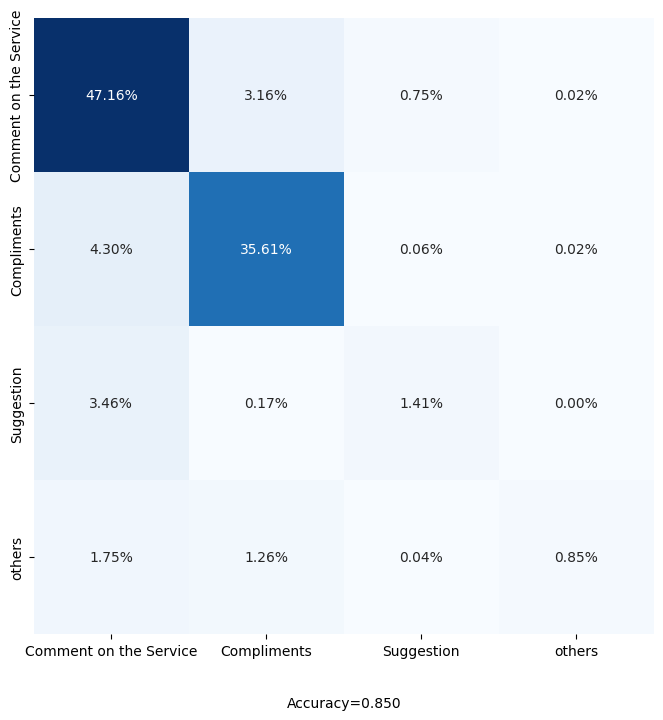

In [47]:
cm = confusion_matrix(y_test, y_pred)
make_confusion_matrix(cm, figsize=(8,8), categories=categories, cbar=False)

### Random forest classifier

In [48]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
rf = RandomForestClassifier(n_estimators=300)
rf.fit(x_train, y_train)
y_pred=rf.predict(x_test)
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred, target_names=['Comment on the Service', 'Compliments', 'Suggestion', 'others']))
rfc =  accuracy_score(y_test, y_pred)
print('accuracy_score: ', rfc)

[[2506  182   15   17]
 [ 189 1928    4    8]
 [ 196   12   54    6]
 [  75   73    2   57]]
                        precision    recall  f1-score   support

Comment on the Service       0.84      0.92      0.88      2720
           Compliments       0.88      0.91      0.89      2129
            Suggestion       0.72      0.20      0.31       268
                others       0.65      0.28      0.39       207

              accuracy                           0.85      5324
             macro avg       0.77      0.58      0.62      5324
          weighted avg       0.84      0.85      0.84      5324

accuracy_score:  0.8536814425244177


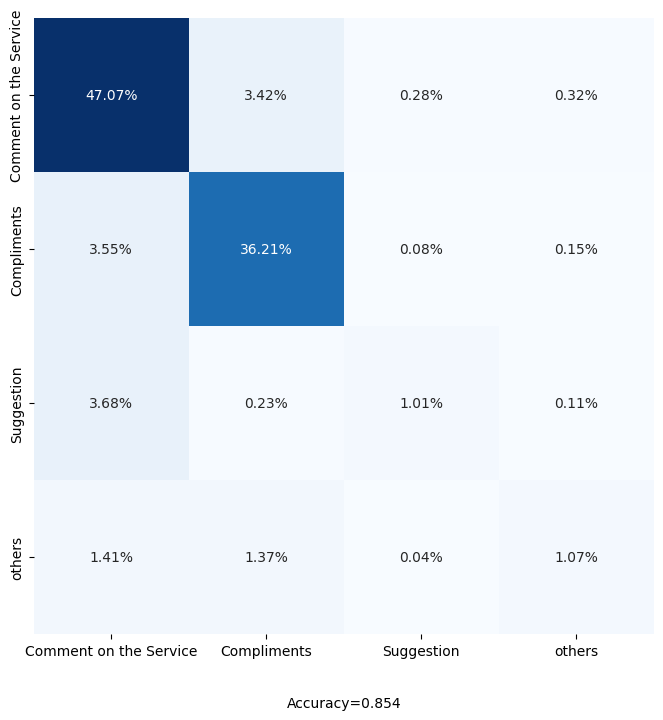

In [49]:
cm = confusion_matrix(y_test, y_pred)
make_confusion_matrix(cm, figsize=(8,8), categories=categories, cbar=False)

### LIGHT GRADIENT BOOSTING CLASSIFIER

In [50]:
import lightgbm as lgb
lgb = lgb.LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=-1,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=400, n_jobs=-1, num_leaves=31, objective=None,
               random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)
lgb.fit(x_train, y_train)
y_pred=lgb.predict(x_test)
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred, target_names=['Comment on the Service', 'Compliments', 'Suggestion', 'others']))
s = accuracy_score(y_test, y_pred)
print('accuracy_score: ', s)

/usr/local/lib/python3.9/dist-packages/lightgbm/sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[[2432  174   92   22]
 [ 195 1921    8    5]
 [ 138   13  117    0]
 [  79   70   10   48]]
                        precision    recall  f1-score   support

Comment on the Service       0.86      0.89      0.87      2720
           Compliments       0.88      0.90      0.89      2129
            Suggestion       0.52      0.44      0.47       268
                others       0.64      0.23      0.34       207

              accuracy                           0.85      5324
             macro avg       0.72      0.62      0.64      5324
          weighted avg       0.84      0.85      0.84      5324

accuracy_score:  0.8486100676183321


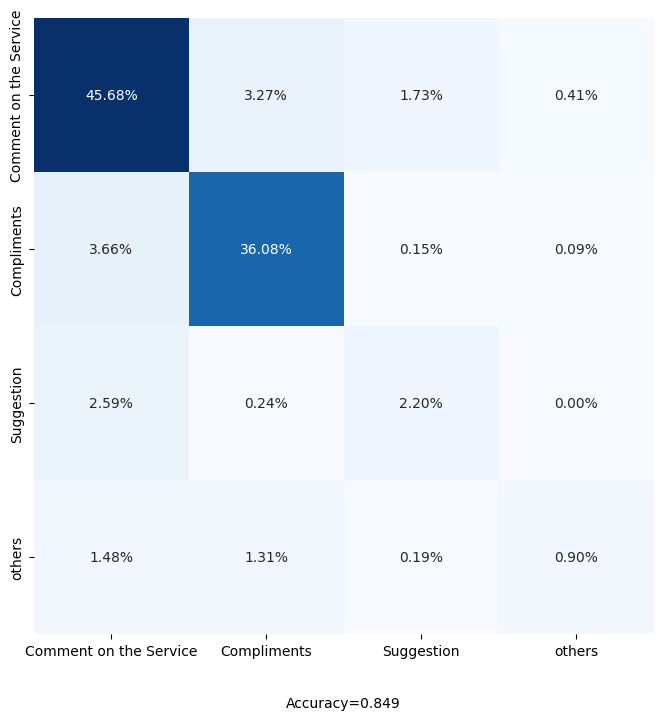

In [51]:
cm = confusion_matrix(y_test, y_pred)
make_confusion_matrix(cm, figsize=(8,8), categories=categories, cbar=False)

### DECISION TREE CLASSIFIER

In [52]:
from sklearn.tree import DecisionTreeClassifier
dt = DecisionTreeClassifier()
dt.fit(x_train, y_train)
y_pred=dt.predict(x_test)
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred, target_names=['Comment on the Service', 'Compliments', 'Suggestion', 'others']))
dtc = accuracy_score(y_test, y_pred)
print('accuracy_score: ', dtc)

[[2358  195  116   51]
 [ 169 1924   14   22]
 [ 118   24  112   14]
 [  62   72   14   59]]
                        precision    recall  f1-score   support

Comment on the Service       0.87      0.87      0.87      2720
           Compliments       0.87      0.90      0.89      2129
            Suggestion       0.44      0.42      0.43       268
                others       0.40      0.29      0.33       207

              accuracy                           0.84      5324
             macro avg       0.65      0.62      0.63      5324
          weighted avg       0.83      0.84      0.83      5324

accuracy_score:  0.8364012021036814


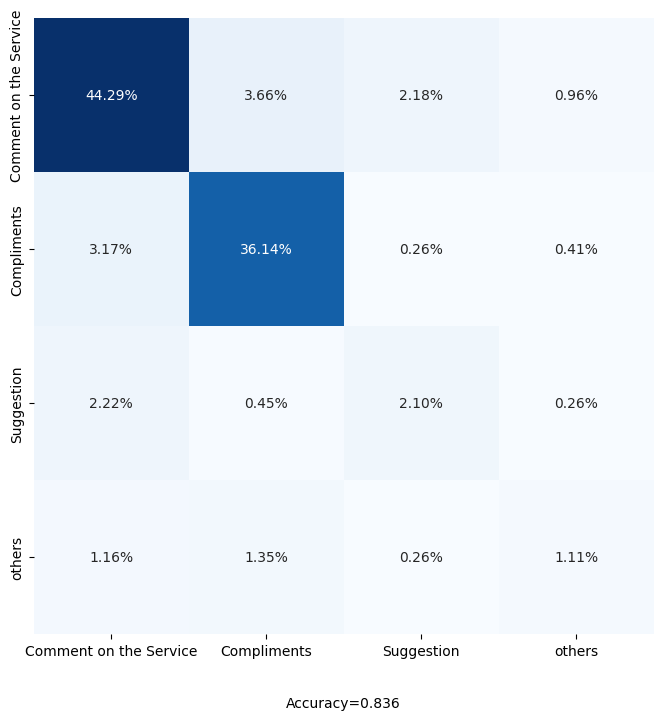

In [53]:
cm = confusion_matrix(y_test, y_pred)
make_confusion_matrix(cm, figsize=(8,8), categories=categories, cbar=False)

### Comparison

In [54]:
accuracy_df = pd.DataFrame({'Model': ['Linear SVM', 'Passive Aggressive classifier', 'Multinomial Naive Bayes', 'Logistic regression', 'Random forest', 'Light GBM', 'Decision tree'], 
                            'Accuracy': [lsvm, pa, nb, log,  rfc, s, dtc]})
accuracy_df

,Model,Accuracy
0,Linear SVM,0.842787
1,Passive Aggressive classifier,0.830015
2,Multinomial Naive Bayes,0.843539
3,Logistic regression,0.850301
4,Random forest,0.853681
5,Light GBM,0.848610
6,Decision tree,0.836401


In [55]:
import warnings
warnings.filterwarnings('ignore')

### Model evaluation

In [56]:
test = "satisfied"
data = [test]
fact = cv.transform(data).toarray()
pred = rf.predict(fact)
#print("pred", pred)
if (int(pred)==0):
  print("Comment on the Service")
elif (int(pred)==1):
  print("Compliments")
elif (int(pred)==2):
  print("Suggestion")
else:
 print("others")

Comment on the Service


In [57]:
test = "Thanks"
data = [test]
fact = cv.transform(data).toarray()
pred = rf.predict(fact)
#print("pred", pred)
if (int(pred)==0):
  print("Comment on the Service")
elif (int(pred)==1):
  print("Compliments")
elif (int(pred)==2):
  print("Suggestion")
else:
 print("others")

Compliments


In [58]:
test = "Please make the refund option smooth and available without difficulties"
data = [test]
fact = cv.transform(data).toarray()
pred = rf.predict(fact)
#print("pred", pred)
if (int(pred)==0):
  print("Comment on the Service")
elif (int(pred)==1):
  print("Compliments")
elif (int(pred)==2):
  print("Suggestion")
else:
 print("others")

Comment on the Service


In [59]:
test = "Az_alharm@icloud.com"
data = [test]
fact = cv.transform(data).toarray()
pred = rf.predict(fact)
#print("pred", pred)
if (int(pred)==0):
  print("Comment on the Service")
elif (int(pred)==1):
  print("Compliments")
elif (int(pred)==2):
  print("Suggestion")
else:
 print("others")

others


### English translation for arabic text

In [60]:
!pip install translate

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [66]:
from translate import Translator
translator= Translator(from_lang="arabic",to_lang="english")
input = "رسالة خطأ في النظام"
translation = translator.translate(input)
print("Engligh translation for arabic text :", translation)
data = [translation]
fact = cv.transform(data).toarray()
pred = rf.predict(fact)
#print("pred", pred)
if (int(pred)==0):
  print("Comment on the Service")
elif (int(pred)==1):
  print("Compliments")
elif (int(pred)==2):
  print("Suggestion")
else:
 print("others")

Engligh translation for arabic text : System error.
Comment on the Service
